In [1]:
import cv2
from PIL import Image
import numpy as np
from selective_search import SelectiveSearch
import matplotlib.pyplot as plt
import scipy
from mpl_toolkits.mplot3d import Axes3D
# from skimage.segmentation import flood_fill
import seaborn as sns

# Requiements for Camera
* Color accuracy
* Resolution

# ROI

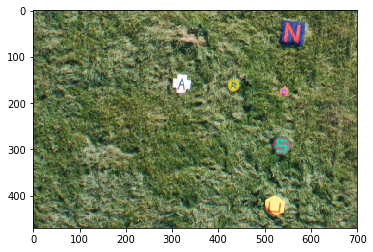

In [2]:
imrgb = cv2.cvtColor(cv2.imread('map.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(imrgb)

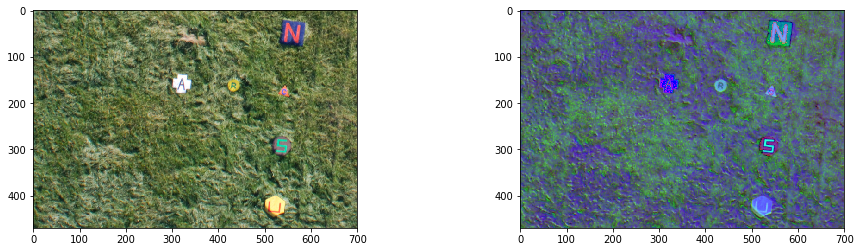

In [3]:
plt.figure(figsize=(16,4))
imrgb = cv2.cvtColor(cv2.imread('map.jpg'), cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(imrgb)
im = cv2.cvtColor(cv2.imread('map.jpg'), cv2.COLOR_RGB2HSV)
plt.subplot(1,2,2)
plt.imshow(im)

In [4]:

from skimage.filters import sobel
elevation_map1 = sobel(im[:,:,0])
elevation_map2 = sobel(im[:,:,1])
elevation_map3 = sobel(im[:,:,2])
elevation_mapa = sobel(imrgb[:,:,0])
elevation_mapb = sobel(imrgb[:,:,1])
elevation_mapc = sobel(imrgb[:,:,2])

mean_map = np.max([elevation_map1, elevation_map2, elevation_map3,elevation_mapa, elevation_mapb, elevation_mapc],axis=0)
mean_map = mean_map * 255
mean_map.shape

(470, 700)

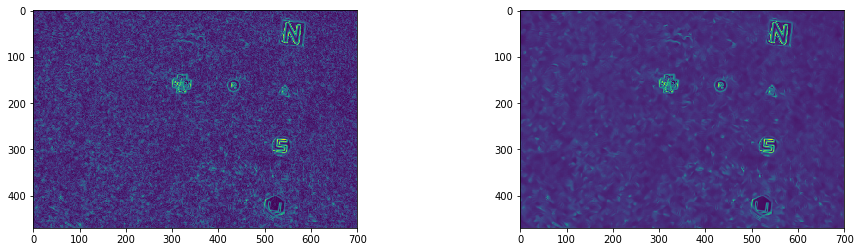

In [5]:
plt.figure(figsize=(16,4))
ims = np.uint8(mean_map)
plt.subplot(1,2,1)
plt.imshow(ims)

dst = cv2.fastNlMeansDenoising(ims,h=10, searchWindowSize=10)
plt.subplot(1,2,2)
plt.imshow(dst)

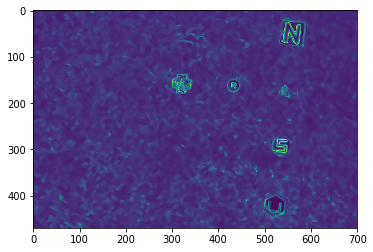

In [6]:
dst = cv2.fastNlMeansDenoising(ims,h=10, searchWindowSize=10)
plt.imshow(dst)

In [7]:
def draw_ROI(img, keypoints):
    imOut = img.copy()
    for kp in keypoints:
        x,y = kp.pt      #Center of keypoint
        x,y = int(x), int(y)
        r = int(kp.size/2)    #Radius of Keypoint
#         print((x,y,r))
        cv2.rectangle(imOut, (x-r, y-r), (x + 2*r, y + 2*r), (0, 255, 0), 1, cv2.LINE_AA)
    plt.imshow(imOut)

In [8]:
SURF_HESSIAN = 500
SURF_OCTAVES = 10
SURF_LAYERS = 10
# DIL_KERNEL_SIZE = (5,5)

Keypoints found: 155


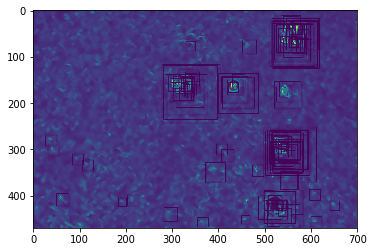

In [9]:
# img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)?
# img = img_rgb

#Dilate images to eliminate grain
# kernel = np.ones(DIL_KERNEL_SIZE,np.uint8)
# img = cv2.dilate(img,kernel,iterations = 2)
# Create SURF 

# img = markers

surf = cv2.xfeatures2d.SURF_create(hessianThreshold=SURF_HESSIAN, nOctaves=SURF_OCTAVES, nOctaveLayers=SURF_LAYERS, upright=True)
keypoints, descriptors = surf.detectAndCompute(dst, None)
imf = cv2.drawKeypoints(dst, keypoints, None)

draw_ROI(dst, keypoints)
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,4))
# ax1.imshow(dst)
# ax1.set_title('Unprocessed HSV')
# ax2.imshow(imf)
# ax2.set_title('Post Dilation and SURF')
print('Keypoints found: {}'.format(len(keypoints)))

In [10]:
imOut = dst.copy()
bboxes = []
for kp in keypoints:
    x,y = kp.pt      #Center of keypoint
    x,y = int(x), int(y)
    r = int(kp.size/2)    #Radius of Keypoint
#         print((x,y,r))
    bboxes.append((x-r, y-r,x + 2*r, y + 2*r))
    

Rectangles Found: 6


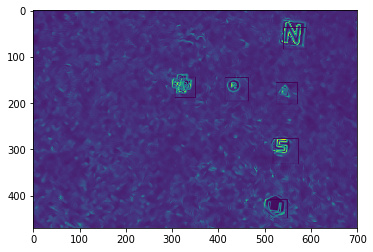

In [11]:
imOut = dst.copy()
rec = cv2.groupRectangles(bboxes,2,0.1)
plt.figure()
print('Rectangles Found: {}' .format(len(rec[0])))
for r in rec[0]:
    cv2.rectangle(imOut, (r[0], r[1]), (r[2], r[3]), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut);

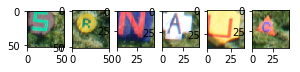

In [12]:
crops = []
plt.figure(figsize=(16,16))
count = 1
for r in rec[0]:
    crop = imrgb[int(r[1]):int(r[3]), int(r[0]):int(r[2])]
    crops.append(crop)
    
    plt.subplot(5,20,count)
    count +=1
    plt.imshow(crop)

 # Background Segmentation (Come back to this)

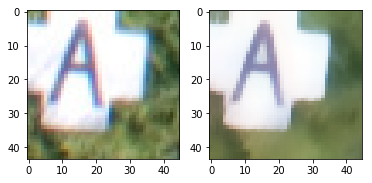

In [162]:
cropped = crops[3]
cropped_hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)
blur = cv2.bilateralFilter(cropped,10,100,100)
elevation_map1 = sobel(blur[:,:,0])
elevation_map2 = sobel(blur[:,:,1])
elevation_map3 = sobel(blur[:,:,2])
# elevation_mapa = sobel(cropped_hsv[:,:,0])
# elevation_mapb = sobel(cropped_hsv[:,:,1])
# elevation_mapc = sobel(cropped_hsv[:,:,2])

mean_map = np.max([elevation_map1, elevation_map2, elevation_map3],axis=0)
mean_map = mean_map * 255
mean_map.shape


plt.figure()
plt.subplot(1,2,1)
plt.imshow(cropped)
plt.subplot(1,2,2)
plt.imshow(blur)

In [14]:
cropped_hsv = cv2.cvtColor(cropped, cv2.COLOR_RGB2HSV)

In [15]:
elevation_map = sobel(cropped[:,:,0]) * 255

In [143]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
color_data = np.reshape(blur, (-1, 3))
clf = KMeans(n_clusters=3, )
clf.fit(color_data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
color_data = np.reshape(blur, (-1, 3))
segmented = np.reshape(clf.predict(color_data), cropped.shape[:2])

In [128]:
mask = np.where((segmented == 0)==True, 1, 0).astype('uint8')
mask = scipy.ndimage.morphology.binary_fill_holes(mask)

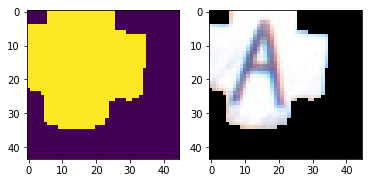

In [164]:
plt.subplot(1,2,1)
plt.imshow(mask)

expmask = np.repeat(np.expand_dims(mask,axis=2), 3, axis=2)
segmented_whole = cropped * expmask

plt.subplot(1,2,2)
plt.imshow(segmented_whole)

In [165]:
color_data = np.reshape(segmented_whole, (-1, 3))
clf = KMeans(n_clusters=3)
clf.fit(color_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [166]:
#Colors 
colors = {'white': np.array([(255,255,255),(255,250,250),(255,255,240)]),
            'black': np.array([(0,0,0),(1,1,1),(1,0,1),(0,1,0)]),
            'gray': np.array([(211,211,211),(192,192,192),(169,169,169),(128,128,128),(105,105,105),(119,136,153),(112,128,144)]),
            'red': np.array([(255,160,122),(250,128,114),(233,150,122),(240,128,128),(205,92,92),(220,20,60),(178,34,34),(255,0,0),(139,0,0),(128,0,0),(255,99,71),(255,69,0),(219,112,147)]),
            'blue': np.array([(176,224,230),(173,216,230),(135,206,250),(135,206,235),(0,191,255),(176,196,222),(30,144,255),(100,149,237),(70,130,180),(95,158,160),(123,104,238),(106,90,205),(72,61,139),(65,105,225),(0,0,255),(0,0,205),(0,0,139),(0,0,128),(25,25,112)]),
            'green': np.array([(124,252,0),(127,255,0),(50,205,50),(0,255,0),(34,139,34),(0,128,0),(0,100,0),(173,255,47),(154,205,50),(0,255,127),(0,250,154),(144,238,144),(152,251,152),(143,188,143),(60,179,113),(32,178,170),(46,139,87),(128,128,0),(85,107,47),(107,142,35)]),
            'yellow': np.array([(255,250,205),(250,250,210),(255,239,213),(255,228,181),(255,218,185),(238,232,170),(240,230,140),(189,183,107),(255,255,0)]),
            'purple': np.array([(147,112,219),(238,130,238),(218,112,214),(255,0,255),(186,85,211),(138,43,226),(148,0,211),(153,50,204),(139,0,139),(128,0,128),(75,0,130)]),
            'brown': np.array([(255,248,220),(255,235,205),(255,228,196),(255,222,173),(245,222,179),(222,184,135),(210,180,140),(188,143,143),(244,164,96),(218,165,32),(205,133,63),(210,105,30),(139,69,19),(160,82,45),(165,42,42),(128,0,0)]),
            'orange': np.array([(255,127,80),(255,99,71),(255,165,0),(255,140,0)])}
neigh = KNeighborsClassifier(n_neighbors=2)
color_X = np.array([colors[x] for x in colors.keys()])
color_y = np.array([np.repeat(key, len(colors[key])) for key in colors.keys()])
color_X = np.concatenate(color_X)
color_y = np.concatenate(color_y)
len(color_y) == len(color_X)
neigh.fit(color_X, color_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [167]:
clf.cluster_centers_

array([[ 2.44404523e+02,  2.45342965e+02,  2.47255025e+02],
       [ 2.52953214e-12,  1.43529633e-12, -6.11066753e-13],
       [ 1.54810345e+02,  1.54477011e+02,  1.87057471e+02]])

In [174]:
crounded = clf.predict(color_data)

In [223]:

masks = []
for color in set(crounded):
    masks.append(np.where(color == crounded,1,0).reshape(mask.shape).astype('uint8'))

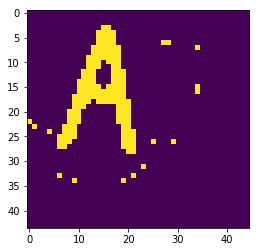

In [224]:
plt.imshow(masks[2])

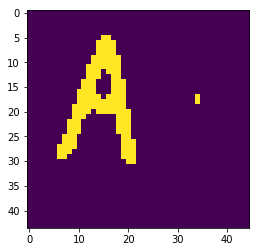

In [233]:
opening = cv2.morphologyEx(masks[2], cv2.MORPH_OPEN, (10,10))
opening = cv2.morphologyEx(opening, cv2.MORPH_OPEN, (10,10))
plt.imshow(opening)